## Visualize MCMC

Load hdf5 file from MCMC_from_file.py that includes experiment meta data, time vs position data, and MCMC results.

In [1]:
# import packages
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import sys
import emcee as mc
import corner
import os

sys.path.insert(0,"../Model")

from trig_fund import *
from dambreak import dambreak
from syrup_prop import Visc

# set default plotting parameters
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)

## Flow of a Herschel-Bulkley fluid on an inclined plane following derivation from Liu & Mei (1989), Balmforth et al. (2007):

$ \frac{\partial h}{\partial t} = -\left( \frac{\rho g}{K} \right)^{1/n} \frac{\partial}{\partial x} \left[ \frac{n \left| \sin{\theta} - \cos{\theta} \frac{\partial h}{\partial x} \right|^{1/n-1} Y^{1+1/n}}{(n+1)(2n+1)} \left[(1+2n)h-nY \right] \left( \sin{\theta} -  \cos{\theta} \frac{\partial h}{\partial x} \right) \right] $

$ Y = h - \frac{\tau_y}{\rho g |\sin{\theta} -\cos{\theta} \frac{\partial h}{\partial x}|} $

For full derivation see included PDF "Viscoplastic Flow Derivation".

In [2]:
title_str = 'MVI_0001' # just change this

filename = 'C:/Users/Janine/Desktop/experiment_outputs/post/'
output_dir = 'C:/Users/Janine/Desktop/experiment_outputs/figs/'
samples = pd.read_hdf(filename + title_str + '.h5', key='s')
samples.head()

,K,tauy,n,theta
0,22.647443,0.474635,0.878090,0.171975
1,22.647443,0.474635,0.878090,0.171975
2,22.326411,0.607642,0.908843,0.129386
3,22.326411,0.607642,0.908843,0.129386
4,23.640087,0.063373,0.783003,0.303661


In [3]:
meta = pd.read_hdf(filename + title_str + '.h5', key='meta')
#meta['Phi_gas'] = 0.37
#meta['Phi_solid'] = 0.186
meta

,H,K_fluid,L,Particle,Phi_gas,Phi_solid,Rho,Slope,Temp,Title,...,theta_post,theta_std,K_Q05,K_Q95,tauy_Q05,tauy_Q95,n_Q05,n_Q95,theta_Q05,theta_Q95
0,0.04,4.715823,0.2,No,0.135,0,1.207,0,27.7,MVI_0001,...,-0.455607,0.384075,16.107417,22.692588,0.114778,4.534106,0.895388,1.464213,-0.528728,0.597791


In [4]:
H = meta.H[0]
L = meta.L[0]
K_fluid = meta.K_fluid[0]
rho = meta.Rho[0]*1000
theta = meta.Slope[0]
T = meta.Temp[0]
phi_gas = meta.Phi_gas[0]
phi_solid = meta.Phi_solid[0]
title_str = meta.Title[0]

try:
    meta.K_post
    K_init = meta.K_post[0]
    tauy_init = meta.tauy_post[0]
    n_init = meta.n_post[0]
    theta_init = meta.theta_post[0]
except AttributeError:
    K_init = meta.K_guess[0]
    tauy_init = meta.tauy_guess[0]
    n_init = meta.n_guess[0]
    theta_init = 0

dat = pd.read_hdf(filename + title_str + '.h5', key='df')

t0 = 0 # Time of dam release [sec]
tloc = int(t0/(dat.Time[1] - dat.Time[0]))
t_pos = dat.Time.iloc[tloc:] - dat.Time.iloc[tloc]
x_pos = dat.X_pos.iloc[tloc:]

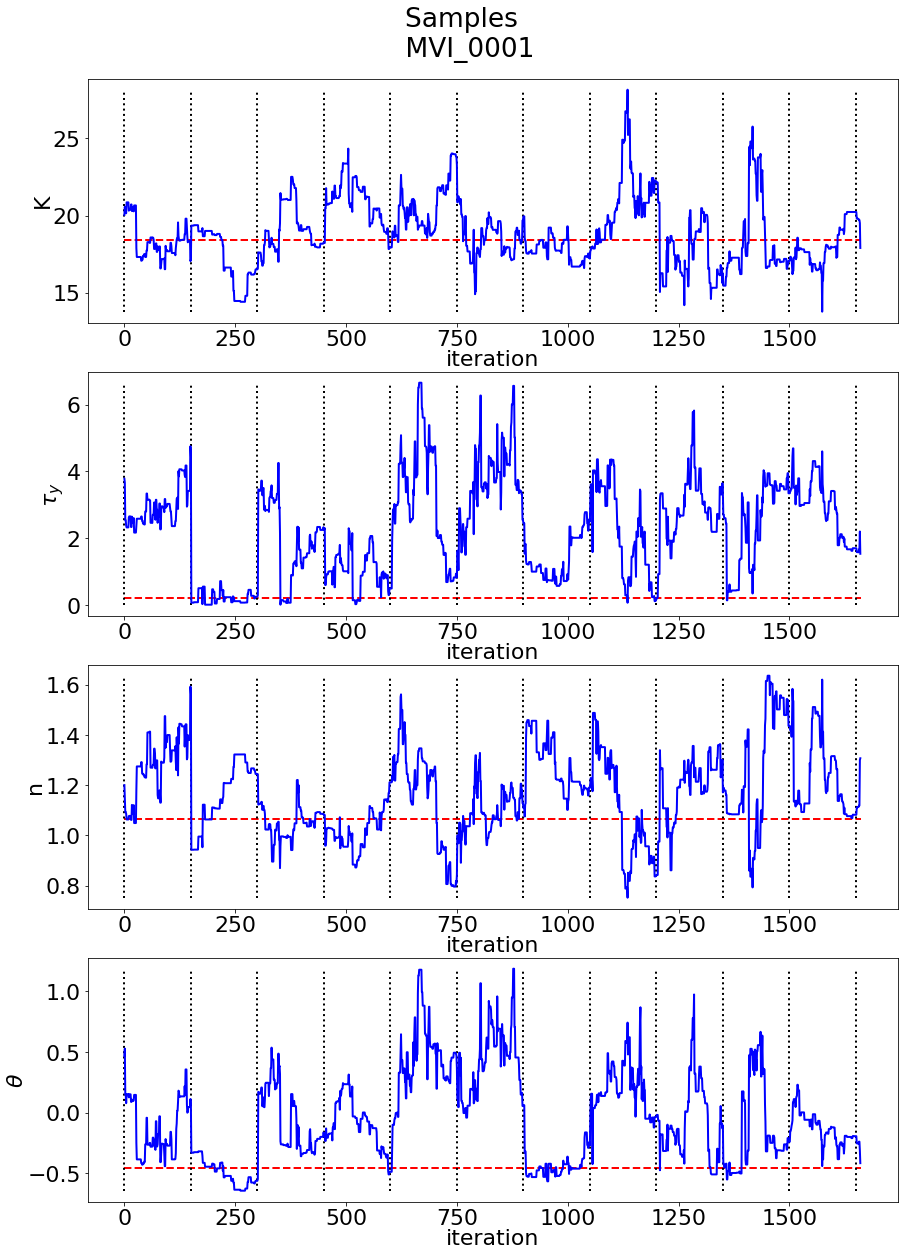

In [8]:
# inspect runs
samples_full = samples.values
nwalkers = 12
steps = 500
s = 350

subset = np.zeros((0,4))

for walker in np.arange(nwalkers):
    subset = np.append(subset,samples_full[(walker*steps + s):((walker + 1)*steps + 1)],axis=0)

samples_full = subset

fig,ax = plt.subplots(nrows=4, figsize=(15,20))
ax[0].plot(samples_full[:,0],'b-')
ax[0].hlines(K_init, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[0].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,0]),np.max(samples_full[:,0]),colors='k',linestyles='dotted')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('K')
ax[1].plot(samples_full[:,1],'b-')
ax[1].hlines(tauy_init, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[1].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,1]),np.max(samples_full[:,1]),colors='k',linestyles='dotted')
ax[1].set_xlabel('iteration')
ax[1].set_ylabel(r'$\tau_y$')
ax[2].plot(samples_full[:,2],'b-')
ax[2].hlines(n_init, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[2].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,2]),np.max(samples_full[:,2]),colors='k',linestyles='dotted')
ax[2].set_xlabel('iteration')
ax[2].set_ylabel('n');
ax[3].plot(samples_full[:,3],'b-')
ax[3].hlines(theta_init, 0, samples_full.shape[0],colors='r',linestyles='dashed')
ax[3].vlines(np.arange(nwalkers)*(steps-s),np.min(samples_full[:,3]),np.max(samples_full[:,3]),colors='k',linestyles='dotted')
ax[3].set_xlabel('iteration')
ax[3].set_ylabel(r'$\theta$');

fig.subplots_adjust(bottom=0.15, top=0.93, left=0.15)
fig.suptitle('Samples \n ' + title_str)
fig.savefig(output_dir + 'Samples_' + title_str + '.pdf')

K = 17.7+5.-1.6
tau_y = 0.18+4.36-0.06
n = 1.08+0.38-0.19
theta = -0.23+0.83-0.3

 
16.1< K <22.7
0.11< tauy <4.53
0.9< n <1.46
-0.53< theta <0.6


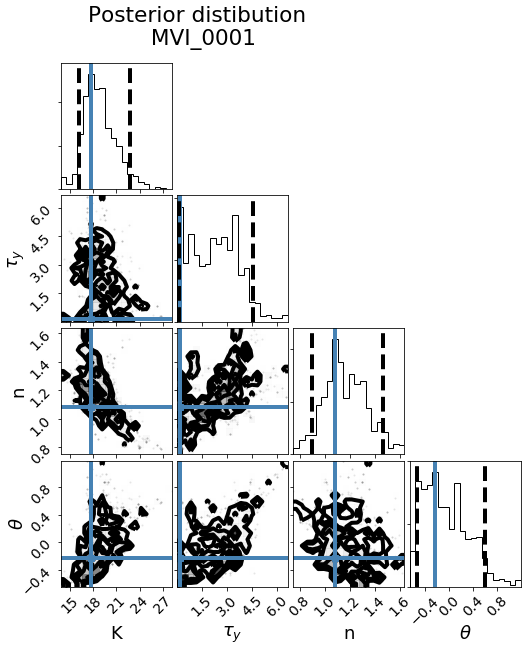

In [9]:
# Inspect MCMC results
# ignore initial samples

K_fit = samples_full[:,0]; tauy_fit = samples_full[:,1]; n_fit = samples_full[:,2]; theta_fit = samples_full[:,3]

# Find mode of each posterior distribution
N, bin_edges = np.histogram(K_fit, bins=20)
K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(tauy_fit, bins=20)
tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(n_fit, bins=20)
n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
N, bin_edges = np.histogram(theta_fit, bins=20)
theta_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

# Find quantiles
K_Q05 = np.quantile(K_fit, .05)
K_Q95 = np.quantile(K_fit, .95)

tauy_Q05 = np.quantile(tauy_fit, .05)
tauy_Q95 = np.quantile(tauy_fit, .95)

n_Q05 = np.quantile(n_fit, .05)
n_Q95 = np.quantile(n_fit, .95)

theta_Q05 = np.quantile(theta_fit, .05)
theta_Q95 = np.quantile(theta_fit, .95)

# set default plotting parameters
plt.rc('font', size=18) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 4.0 #set default line width to 2.0 (from 1.0)
plt.rcParams["axes.labelpad"] = 0

# plot
fig = corner.corner(samples_full, labels=["K", r"$\tau_y$", "n", r"$\theta$"],
                  truths=[K_post, tauy_post, n_post, theta_post], quantiles=[0.05, 0.95], 
                  label_kwargs={'labelpad':10})
for ax in fig.get_axes():  
      ax.tick_params(axis='both', labelsize=14)

fig.subplots_adjust(bottom=0.15, top=0.9, left=0.3)
fig.suptitle('Posterior distibution \n ' + title_str)
fig.savefig(output_dir + 'Corner_' + title_str + '.pdf')

print('K = ' + np.array2string(K_post,precision=1) + 
         '+' + np.array2string(K_Q95 - K_post,precision=1) + 
         '-' + np.array2string(K_post - K_Q05,precision=1) + '\n'
     'tau_y = ' + np.array2string(tauy_post,precision=2) + 
            '+' + np.array2string(tauy_Q95 - tauy_post,precision=2) + 
            '-' + np.array2string(tauy_post - tauy_Q05,precision=2) + '\n'
     'n = ' + np.array2string(n_post,precision=2) + 
         '+' + np.array2string(n_Q95 - n_post,precision=2) + 
         '-' + np.array2string(n_post - n_Q05,precision=2) + '\n'
     'theta = ' + np.array2string(theta_post,precision=2) + 
         '+' + np.array2string(theta_Q95 - theta_post,precision=2) + 
         '-' + np.array2string(theta_post - theta_Q05,precision=2))

print('\n \n' + np.array2string(K_Q05,precision=1) + 
      '< K <' + np.array2string(K_Q95,precision=1) + '\n'
              + np.array2string(tauy_Q05,precision=2) + 
      '< tauy <' + np.array2string(tauy_Q95,precision=2) + '\n'
              + np.array2string(n_Q05,precision=2) + 
      '< n <' + np.array2string(n_Q95,precision=2) + '\n'
                  + np.array2string(theta_Q05,precision=2) + 
      '< theta <' + np.array2string(theta_Q95,precision=2))

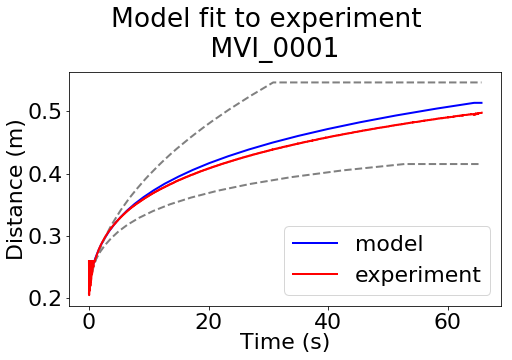

In [10]:
plt.rc('font', size=22) #set default font size to 22 (from 10)
plt.rcParams['lines.linewidth'] = 2.0 #set default line width to 2.0 (from 1.0)

# Plot most probable model with data
x_grid = np.linspace(0,1.2*np.max(x_pos)+L,52)
dx = x_grid[1] - x_grid[0]
h0 = np.zeros_like(x_grid)
h0[x_grid<0.2] = H

# Plot front advance
fig,ax = plt.subplots(figsize=(8,5))

for linspec, K, tauy, n, theta in zip(['b-', 'k--', 'k--'], [K_post, K_Q05, K_Q95], [tauy_post, tauy_Q05, tauy_Q95],
                                     [n_post, n_Q95, n_Q05], [theta_post, theta_Q95, theta_Q05]):

    res = 50
    h, t = dambreak(x_grid, h0, theta, rho, K, tauy, n, 9.81, t_pos.iloc[-1], res*t_pos.size)
    X = np.zeros_like(t_pos)
    t_match = np.zeros_like(t_pos)

    threshold = 0.0001
    for j in np.arange(t_pos.size):
        X[j] = x_grid[np.max(np.nonzero(h[j*res,:]>threshold)) + 1] # find node with h>threshold
        t_match[j] = t[j*res]
        ind = np.nonzero(X[1:] - X[:-1])[0]
        model = np.interp(t_match,t_match[ind],X[ind])
        
    if K == K_post:
        ax.plot(t_match,model,'b-',label='model');
    else:
        ax.plot(t_match,model,color='grey',linestyle='dashed');
        
ax.plot(t_pos,x_pos+L,'r',label='experiment')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (m)')
ax.legend();

fig.subplots_adjust(bottom=0.15, top=0.8, left=0.15)
fig.suptitle('Model fit to experiment \n ' + title_str)
fig.savefig(output_dir + 'Flow_front_' + title_str + '.pdf')

In [ ]:
meta['K_Q05'] = K_Q05
meta['K_Q95'] = K_Q95

meta['tauy_Q05'] = tauy_Q05
meta['tauy_Q95'] = tauy_Q95

meta['n_Q05'] = n_Q05
meta['n_Q95'] = n_Q95

meta['theta_Q05'] = theta_Q05
meta['theta_Q95'] = theta_Q95

meta.to_hdf(filename + title_str + '.h5', key='meta', mode='a')

# Quick

In [ ]:
filepath = 'C:/Users/Janine/Desktop/experiment_outputs/'
vids = os.listdir(filepath + 'logs')

sys.path.insert(0,"C:/Users/Janine/Desktop/experiment_outputs/post/")

for vid in vids:
    title_str = vid.strip('.txt')

#filename = 'C:/Users/Janine/Desktop/experiment_outputs/post/'
#output_dir = 'C:/Users/Janine/Desktop/experiment_outputs/figs/'
    samples = pd.read_hdf(filename + title_str + '.h5', key='s')
    meta = pd.read_hdf(filename + title_str + '.h5', key='meta')

    samples_full = samples.values
    nwalkers = 12
    steps = 500
    s = 350

    subset = np.zeros((0,4))

    for walker in np.arange(nwalkers):
        subset = np.append(subset,samples_full[(walker*steps + s):((walker + 1)*steps + 1)],axis=0)

    samples_full = subset

    K_fit = samples_full[:,0]; tauy_fit = samples_full[:,1]; n_fit = samples_full[:,2]; theta_fit = samples_full[:,3]

    # Find mode of each posterior distribution
    N, bin_edges = np.histogram(K_fit, bins=20)
    K_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
    N, bin_edges = np.histogram(tauy_fit, bins=20)
    tauy_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
    N, bin_edges = np.histogram(n_fit, bins=20)
    n_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 
    N, bin_edges = np.histogram(theta_fit, bins=20)
    theta_post = np.mean([bin_edges[np.argmax(N)], bin_edges[np.argmax(N)+1]]) 

    # Find quantiles
    K_Q05 = np.quantile(K_fit, .05)
    K_Q95 = np.quantile(K_fit, .95)

    tauy_Q05 = np.quantile(tauy_fit, .05)
    tauy_Q95 = np.quantile(tauy_fit, .95)

    n_Q05 = np.quantile(n_fit, .05)
    n_Q95 = np.quantile(n_fit, .95)

    theta_Q05 = np.quantile(theta_fit, .05)
    theta_Q95 = np.quantile(theta_fit, .95)

    meta['K_Q05'] = K_Q05
    meta['K_Q95'] = K_Q95

    meta['tauy_Q05'] = tauy_Q05
    meta['tauy_Q95'] = tauy_Q95

    meta['n_Q05'] = n_Q05
    meta['n_Q95'] = n_Q95

    meta['theta_Q05'] = theta_Q05
    meta['theta_Q95'] = theta_Q95

    meta.to_hdf(filename + title_str + '.h5', key='meta', mode='a')

In [ ]:
meta.to_hdf(filename + title_str + '.h5', key='meta', mode='a')